## 0.0. Imports

In [4]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML
from geopy.geocoders import Nominatim
import geopandas


### 0.2. Helper Functions

In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 18]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

pd.set_option('display.float_format', lambda x: '%.2f' % x)
jupyter_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/heitor/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### 0.3. Loading Data

In [6]:
data = pd.read_csv('kc_house_data2.csv')

## 1.0. Data Description

In [7]:
data.dtypes


Unnamed: 0         int64
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
year               int64
month              int64
day                int64
year_week         object
week               int64
season            object
city              object
state             object
dtype: object

In [8]:
data.shape

(21613, 30)

In [9]:
num_attributes = data.select_dtypes(['int64', 'float64'])


#central tendency
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion
min_ = pd.DataFrame(num_attributes.apply(min)).T
max_ = pd.DataFrame(num_attributes.apply(max)).T
range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
std = pd.DataFrame(num_attributes.apply(np.std)).T
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


In [10]:
#concatenate 

m = pd.concat([min_, max_, range_, mean, median,std,skew,kurtosis]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','std','skew','kurtosis']

#dropping unecessary rows
rows = [0,13,14,15,16,17]
m = m.drop(rows, axis=0)


In [11]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
1,id,1000102.00,9900000190.00,9899000088.00,4580301520.86,3904930410.00,2876499023.43,0.24,-1.26
2,price,75000.00,7700000.00,7625000.00,540088.14,450000.00,367118.70,4.02,34.59
3,bedrooms,0.00,33.00,33.00,3.37,3.00,0.93,1.97,49.06
4,bathrooms,0.00,8.00,8.00,2.11,2.25,0.77,0.51,1.28
5,sqft_living,290.00,13540.00,13250.00,2079.90,1910.00,918.42,1.47,5.24
6,sqft_lot,520.00,1651359.00,1650839.00,15106.97,7618.00,41419.55,13.06,285.08
7,floors,1.00,3.50,2.50,1.49,1.50,0.54,0.62,-0.48
8,waterfront,0.00,1.00,1.00,0.01,0.00,0.09,11.39,127.63
9,view,0.00,4.00,4.00,0.23,0.00,0.77,3.40,10.89
10,condition,1.00,5.00,4.00,3.41,3.00,0.65,1.03,0.53


## 2.0. Feature Engineering

In [12]:
#to datetime
data['date'] = pd.to_datetime(data['date'])

#year
data['year'] = data['date'].dt.year

#month
data['month'] = data['date'].dt.month

#day
data['day'] = data['date'].dt.day

#year-week
data['year_week'] = data['date'].dt.strftime("%Y-%W")

#week
data['week'] = data['date'].dt.isocalendar().week

#season 
data['season'] = data['month'].apply(lambda x: 'summer' if (x>=6) & (x<=8) else 
                                                'fall' if (x>=9) & (x<=11) else
                                                'spring' if (x>=3) & (x<=5) else
                                                'winter')

### 2.1. Endereços via API

In [14]:
#initialize API
geolocator = Nominatim( user_agent='geoapiExercises' )

response = geolocator.reverse('47.51 ,-122.26')
response.raw

{'place_id': 158810523,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 236673776,
 'lat': '47.50987735',
 'lon': '-122.26001908123574',
 'display_name': '5746, South Ryan Street, Rainier Beach, Seattle, King County, Washington, 98178, United States',
 'address': {'house_number': '5746',
  'road': 'South Ryan Street',
  'neighbourhood': 'Rainier Beach',
  'city': 'Seattle',
  'county': 'King County',
  'state': 'Washington',
  'ISO3166-2-lvl4': 'US-WA',
  'postcode': '98178',
  'country': 'United States',
  'country_code': 'us'},
 'boundingbox': ['47.509808', '47.5099694', '-122.2600792', '-122.259959']}

In [80]:
#create empty rows
# data['city'] = 'NA'
# data['state'] = 'NA'

In [81]:

# for i in range( len( data ) ):
#     print( 'Loop: {}/{}'.format( i, len( data ) ) )
#     # make request
#     query = str( data.loc[i, 'lat'] ) + ',' + str( data.loc[i, 'long'] )
#     response = geolocator.reverse(query)
#     if 'city' in response.raw['address']:
#         data.loc[i,'city'] = response.raw['address']['city']
#     if 'state' in response.raw['address']:
#         data.loc[i,'state'] = response.raw['address']['state']

In [55]:
# for i in range(len(data) ):
#     print( 'Loop: {}/{}'.format( i, len( data ) ) )
#     # make request

#     query = str( data.loc[i, 'lat'] ) + ',' + str( data.loc[i, 'long'] )
#     response = geolocator.reverse(query)
#     if 'city' in response.raw['address']:
#         data.loc[i,'city'] = response.raw['address']['city']
#     if 'state' in response.raw['address']:
#         data.loc[i,'state'] = response.raw['address']['state']
 


Loop: 4280/21613
Loop: 4281/21613
Loop: 4282/21613
Loop: 4283/21613
Loop: 4284/21613
Loop: 4285/21613


In [56]:
# data.to_csv('kc_house_data2.csv')
# data2 = pd.read_csv('kc_house_data2.csv')
# data2.isna().sum()


Unnamed: 0          0
Unnamed: 0.1        0
id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
year                0
month               0
day                 0
year_week           0
week                0
season              0
city             5778
state               0
dtype: int64

## 3.0. Filtragem de variáveis

In [84]:
#nothing to filter

## 4.0. Análise Exploratória de Dados


### 4.1. Análise Univariada

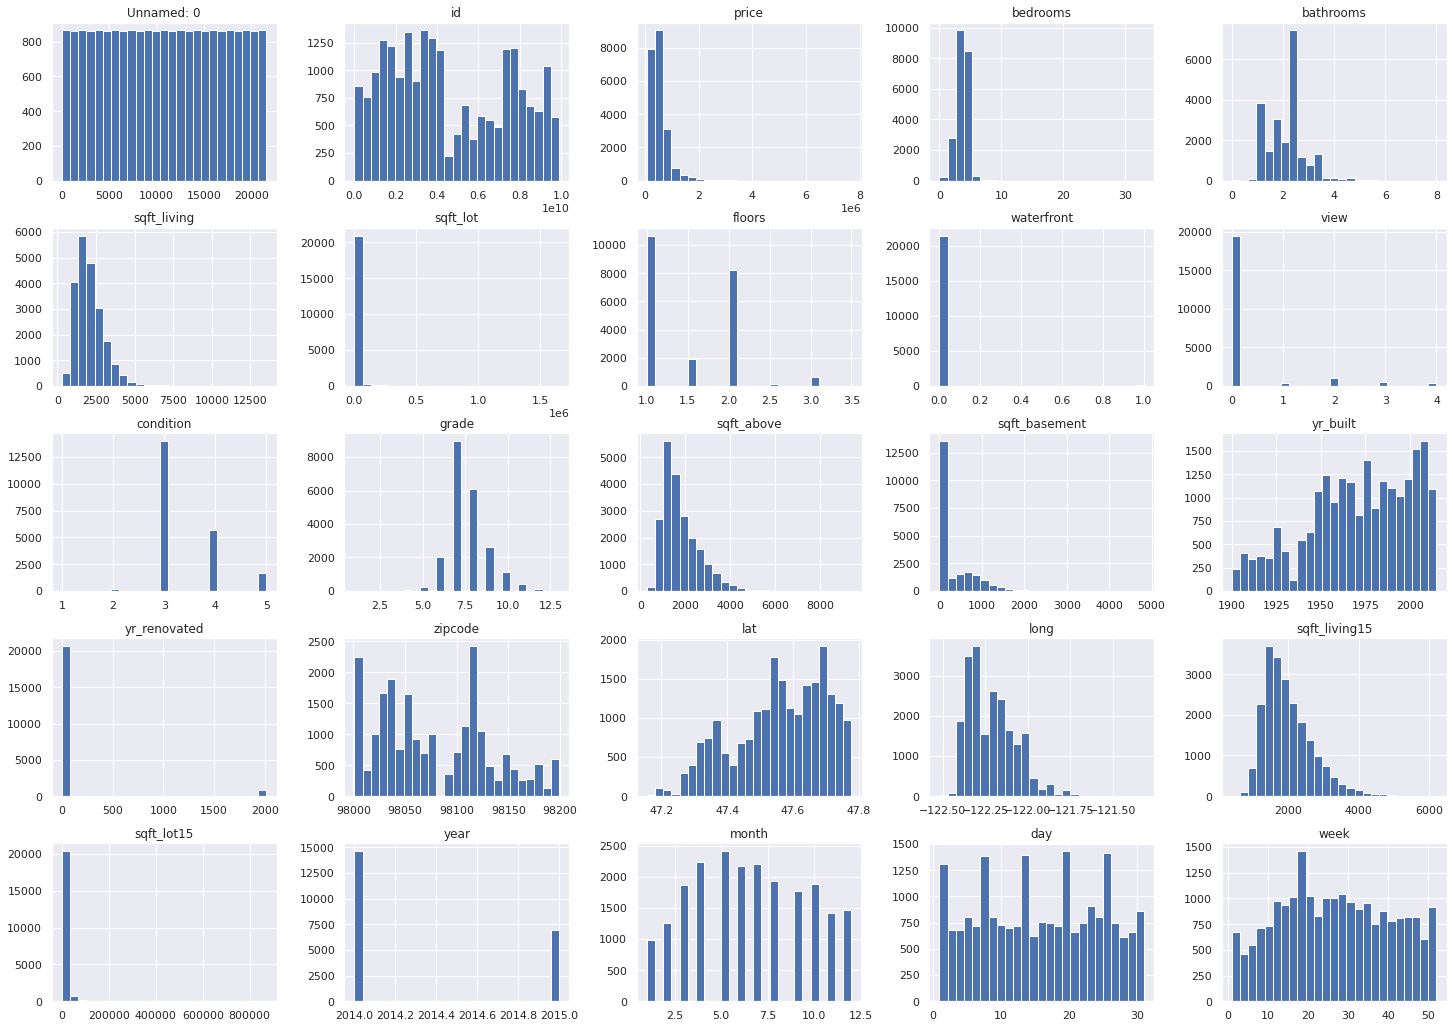

In [85]:
num_attributes.hist(bins=25);

/home/heitor/repos/house_rocket/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


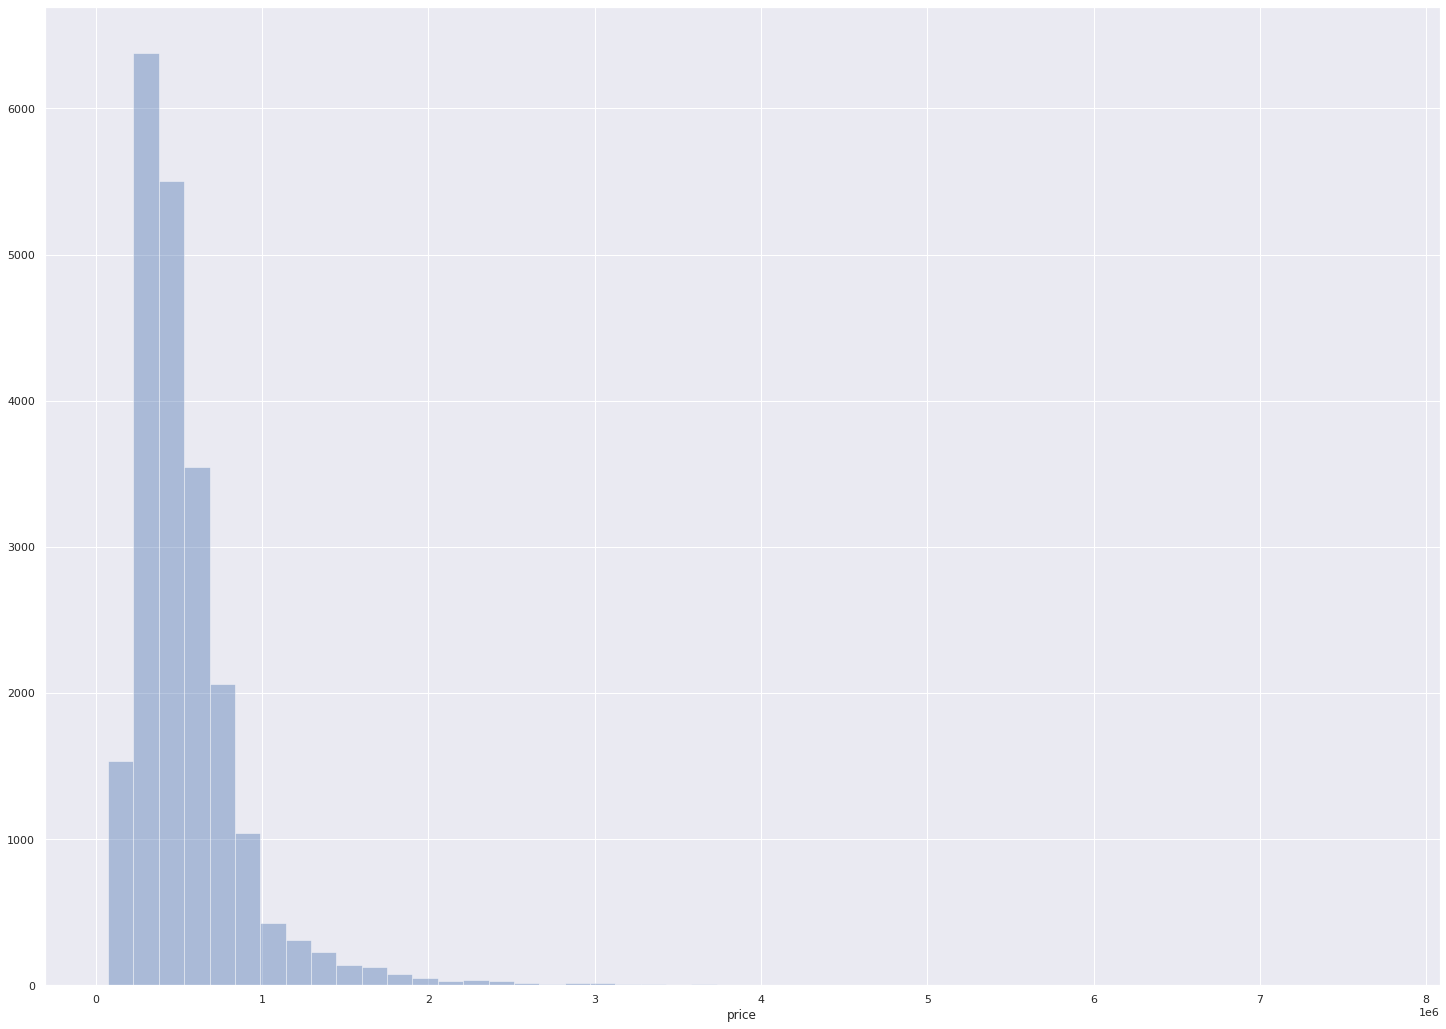

In [86]:
sns.distplot( data['price'], kde=False );

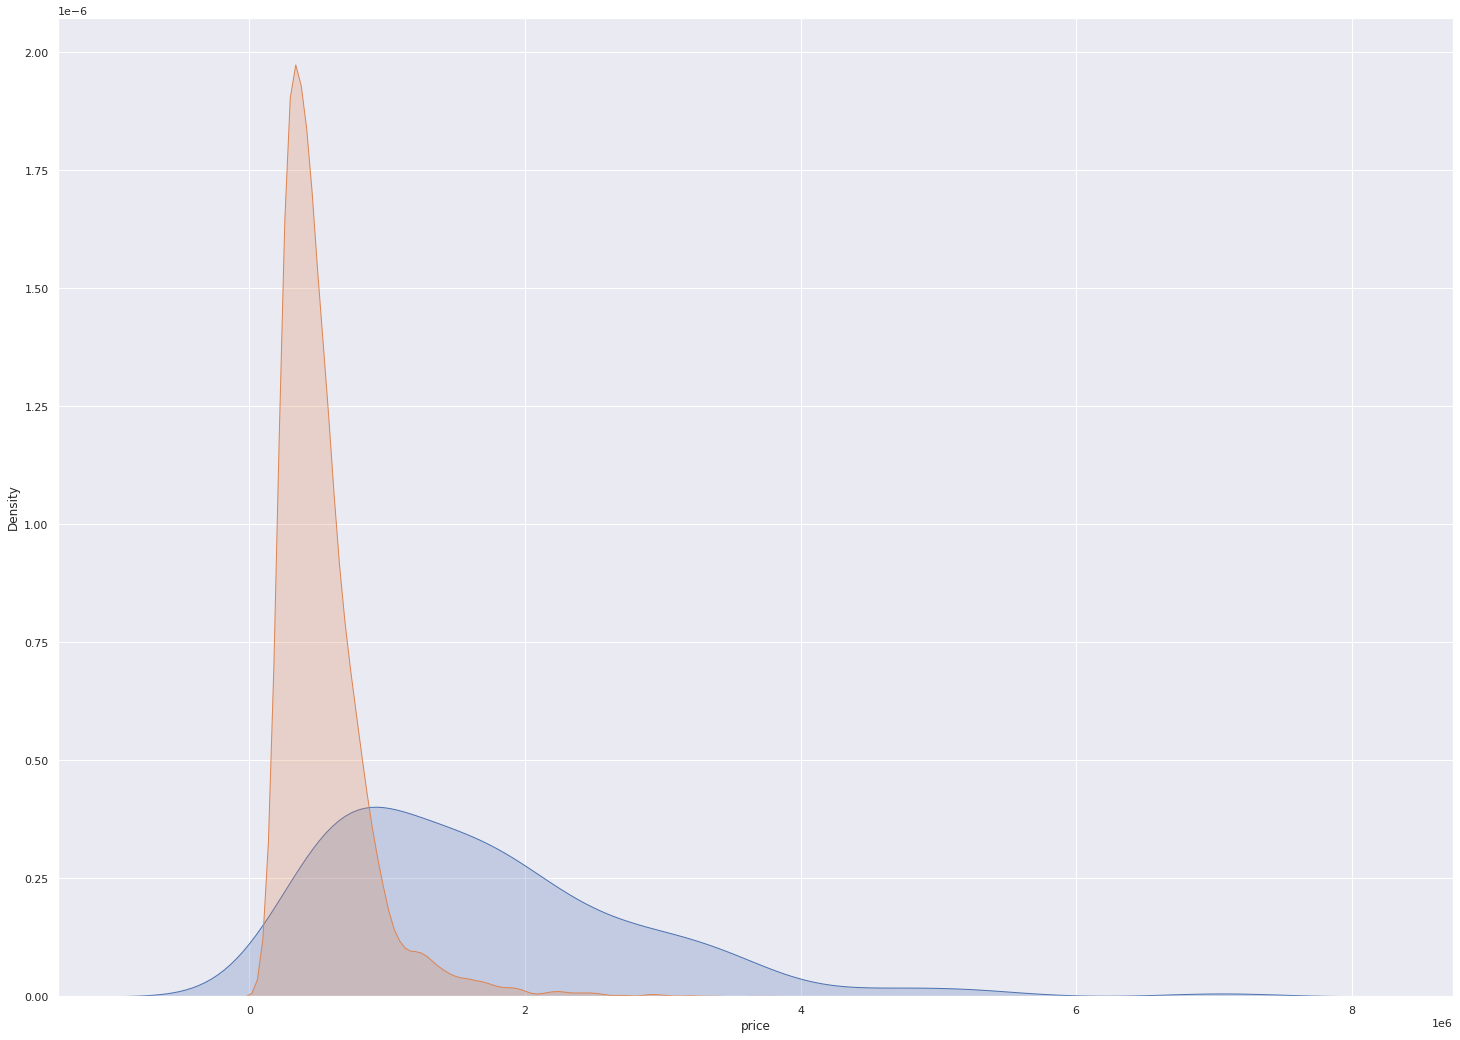

In [87]:
sns.kdeplot(data[data['waterfront']==1]['price'], label='waterfront', shade=True, legend=True);
sns.kdeplot(data[data['waterfront']==0]['price'], label='no_waterfront', shade=True, legend=True);



/home/heitor/repos/house_rocket/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/heitor/repos/house_rocket/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/heitor/repos/house_rocket/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

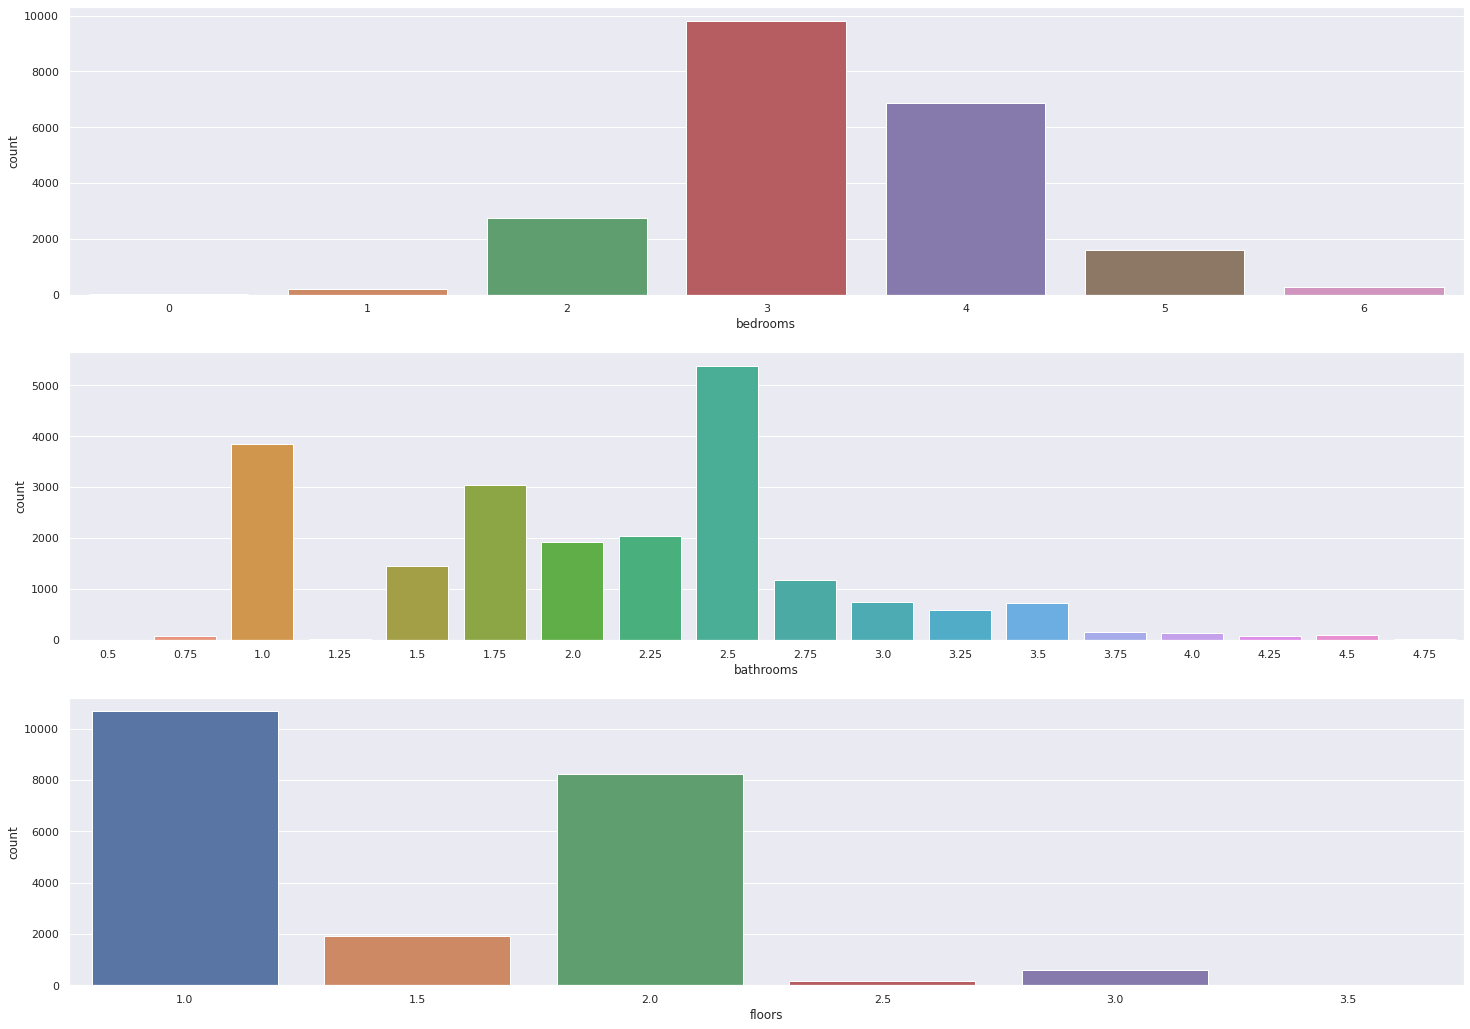

In [88]:
# bedrooms 
#bathrooms
#floors

#waterfront
#view
#condition

plt.subplot(3,1,1)
aux = data[data['bedrooms']<7]
sns.countplot(aux['bedrooms']);

plt.subplot(3,1,2)
aux2 = data[(data['bathrooms']!=0) & (data['bathrooms']<5)]
sns.countplot(aux2['bathrooms'])

plt.subplot(3,1,3)
sns.countplot(data['floors']);



### 4.2. Análise Bivariada

In [89]:
data.columns

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year',
       'month', 'day', 'year_week', 'week', 'season', 'city', 'state'],
      dtype='object')

#### 4.2.1. Hipóteses

#### H1. Casas vendidas no verão são mais caras e no inverno, mais baratas


Falso: Casas vendidas na primavera são as mais caras


In [90]:
aux = data[['season','price']].groupby('season').mean().reset_index()
# sns.barplot(x='season',y='price', data=aux);
aux

,season,price
0,fall,530846.52
1,spring,552603.24
2,summer,546781.96
3,winter,519221.24


#### H2. A cada banheiro, o valor médio do imóvel sobe pelo menos 5%

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

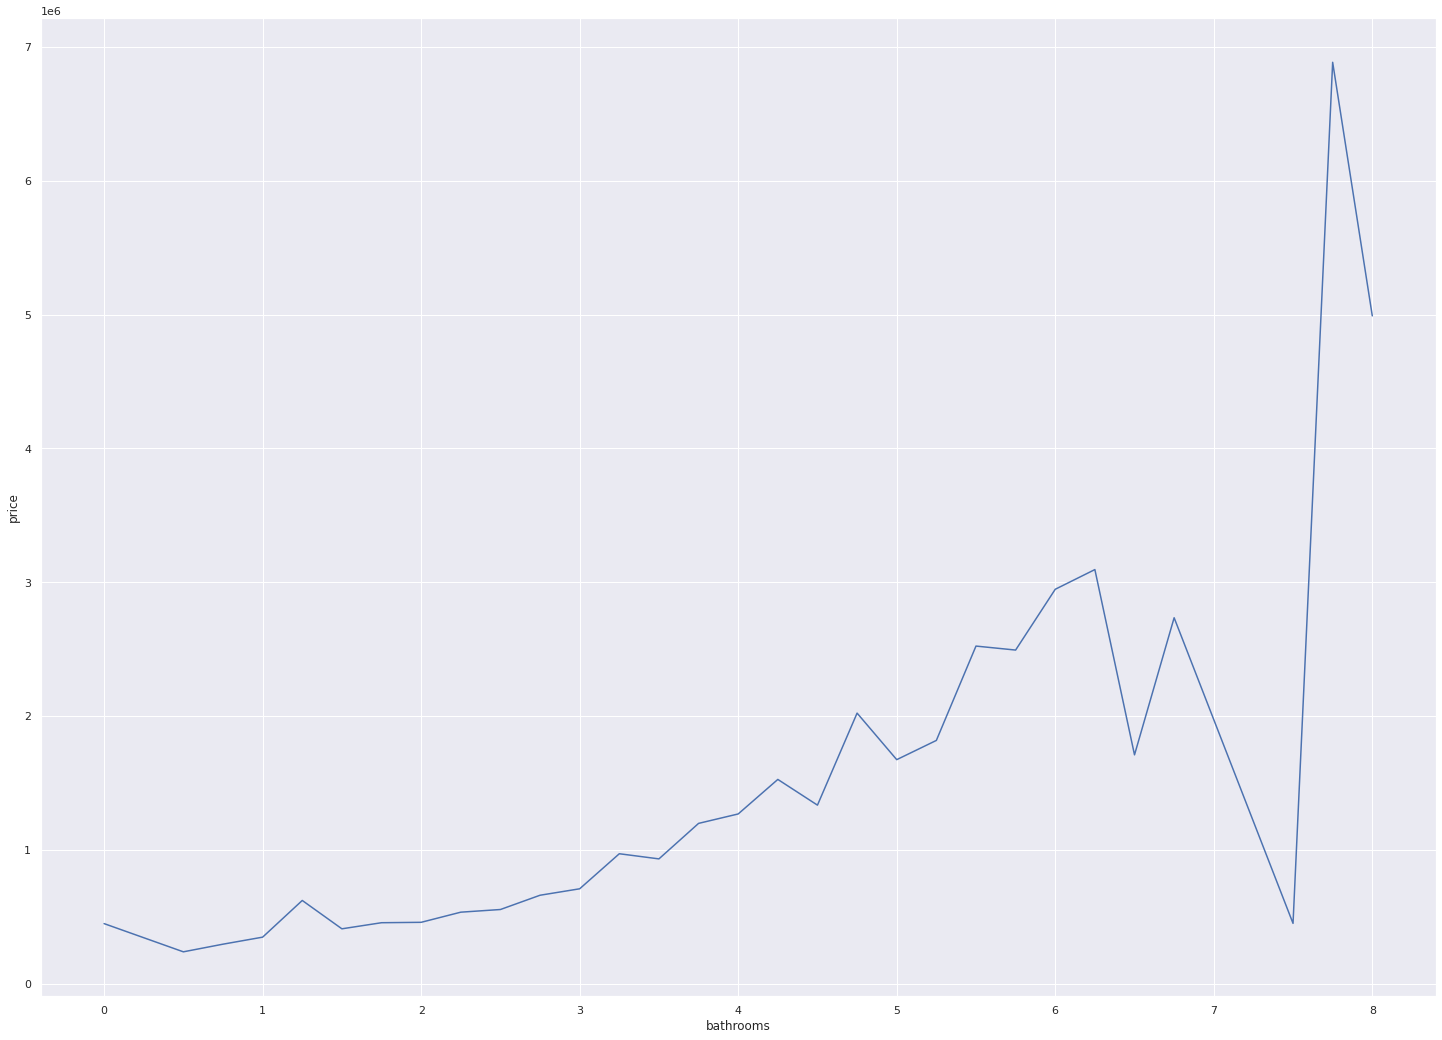

In [91]:
aux = data[['bathrooms','price']].groupby('bathrooms').mean().reset_index()

for i in range(0,len(aux)-1):
    aux.loc[i+1,'difference'] = (aux.loc[i+1,'price'] - aux.loc[i,'price'])/aux.loc[i,'price']

    
sns.lineplot(x='bathrooms',y='price', data=aux)    

In [92]:
aux

,bathrooms,price,difference
0,0.00,448160.00,NaN
1,0.50,237375.00,-0.47
2,0.75,294520.86,0.24
3,1.00,347041.24,0.18
4,1.25,621216.67,0.79
5,1.50,409322.21,-0.34
6,1.75,454896.10,0.11
7,2.00,457889.72,0.01
8,2.25,533676.77,0.17
9,2.50,553596.50,0.04


#### H3. A cada quarto, o valor do imóvel sobe pelo menos 8%

Falso: O comportamento não vale sempre, porém na maior parte é verdade

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

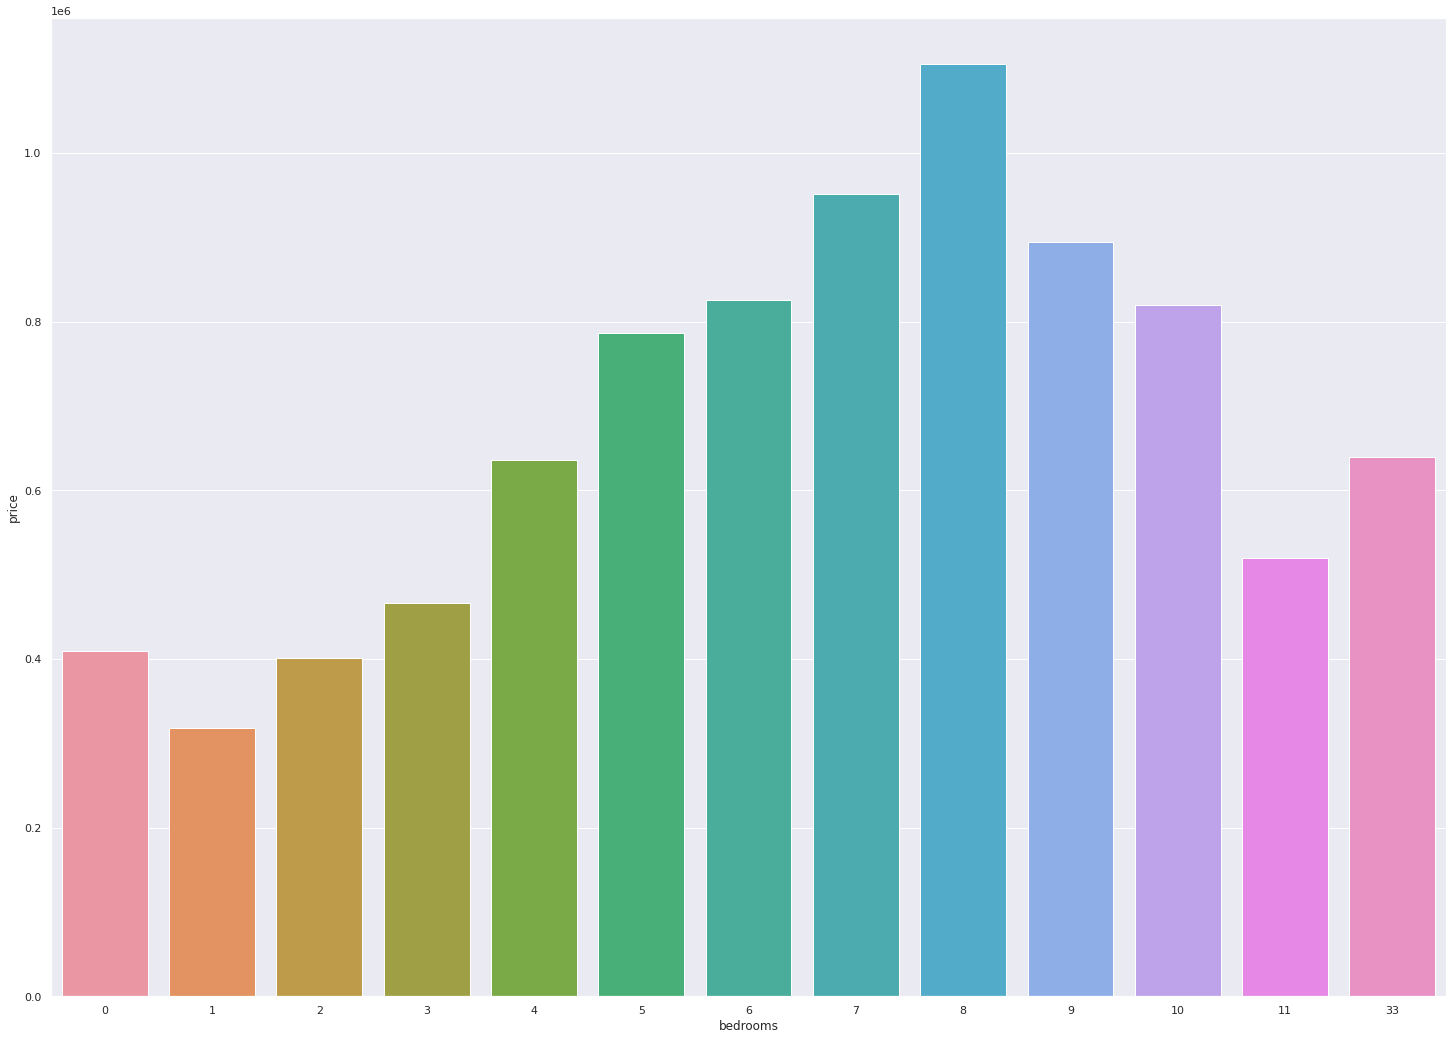

In [93]:
aux = data[['bedrooms','price']].groupby('bedrooms').mean().reset_index()


for i in range(0,len(aux)-1):
    aux.loc[i+1,'difference'] = (aux.loc[i+1,'price'] - aux.loc[i,'price'])/aux.loc[i,'price']
sns.barplot(x='bedrooms',y='price',data=aux)


In [94]:
aux

,bedrooms,price,difference
0,0,409503.85,NaN
1,1,317642.88,-0.22
2,2,401372.68,0.26
3,3,466232.08,0.16
4,4,635419.50,0.36
5,5,786599.83,0.24
6,6,825520.64,0.05
7,7,951184.66,0.15
8,8,1105076.92,0.16
9,9,893999.83,-0.19


#### H4. Imóveis com vista para o mar é pelo menos 50% mais caro que as demais, em média

Verdade, imóveis com vista para ao mar é mais que 50% mais caro que os demais

In [95]:


aux = data[['waterfront','price']].groupby('waterfront').mean().reset_index()
aux

,waterfront,price
0,0,531563.60
1,1,1661876.02


#### H5. Casas com porões, são pelo menos 10% mais baratas que as demais.

Falso: Casas com porão são 27% mais caras em média.

In [96]:
data['basement'] = data['sqft_basement'].apply(lambda x: 'yes' if x>0 else 'no')

aux = data[['basement','price']].groupby('basement').mean().reset_index()
aux

,basement,price
0,no,486884.09
1,yes,622373.56


#### H6. O valor/m² do imóvel de frente para o mar é 50% mais caro que os demais 

Falso: Imóveis de frente ao mar sãol 37% mais caros

In [97]:
data.head()
data['m2'] = data['sqft_lot']*0.09290304
data['price_m2'] = data['price']/data['m2']

aux = data[['waterfront','price_m2']].groupby('waterfront').mean().reset_index()

aux

,waterfront,price_m2
0,0,954.93
1,1,1313.07


#### H7. Os imóveis são mais caros no primeiro semestre do ano

Falso: Não há diferença relevante em relação ao semestre do ano

In [101]:
data['semester'] = data['month'].apply(lambda x: 1 if x < 7 else 2)

aux = data[['semester','price']].groupby('semester').mean().reset_index()

aux

,semester,price
0,1,546168.91
1,2,533869.08


#### H8. A cada andar do imóvel, o valor aumenta pelo menos 5%

Verdade: É verdade, exceto para imóveis com 3 andares, que é mais barato.

<AxesSubplot:xlabel='floors', ylabel='price'>

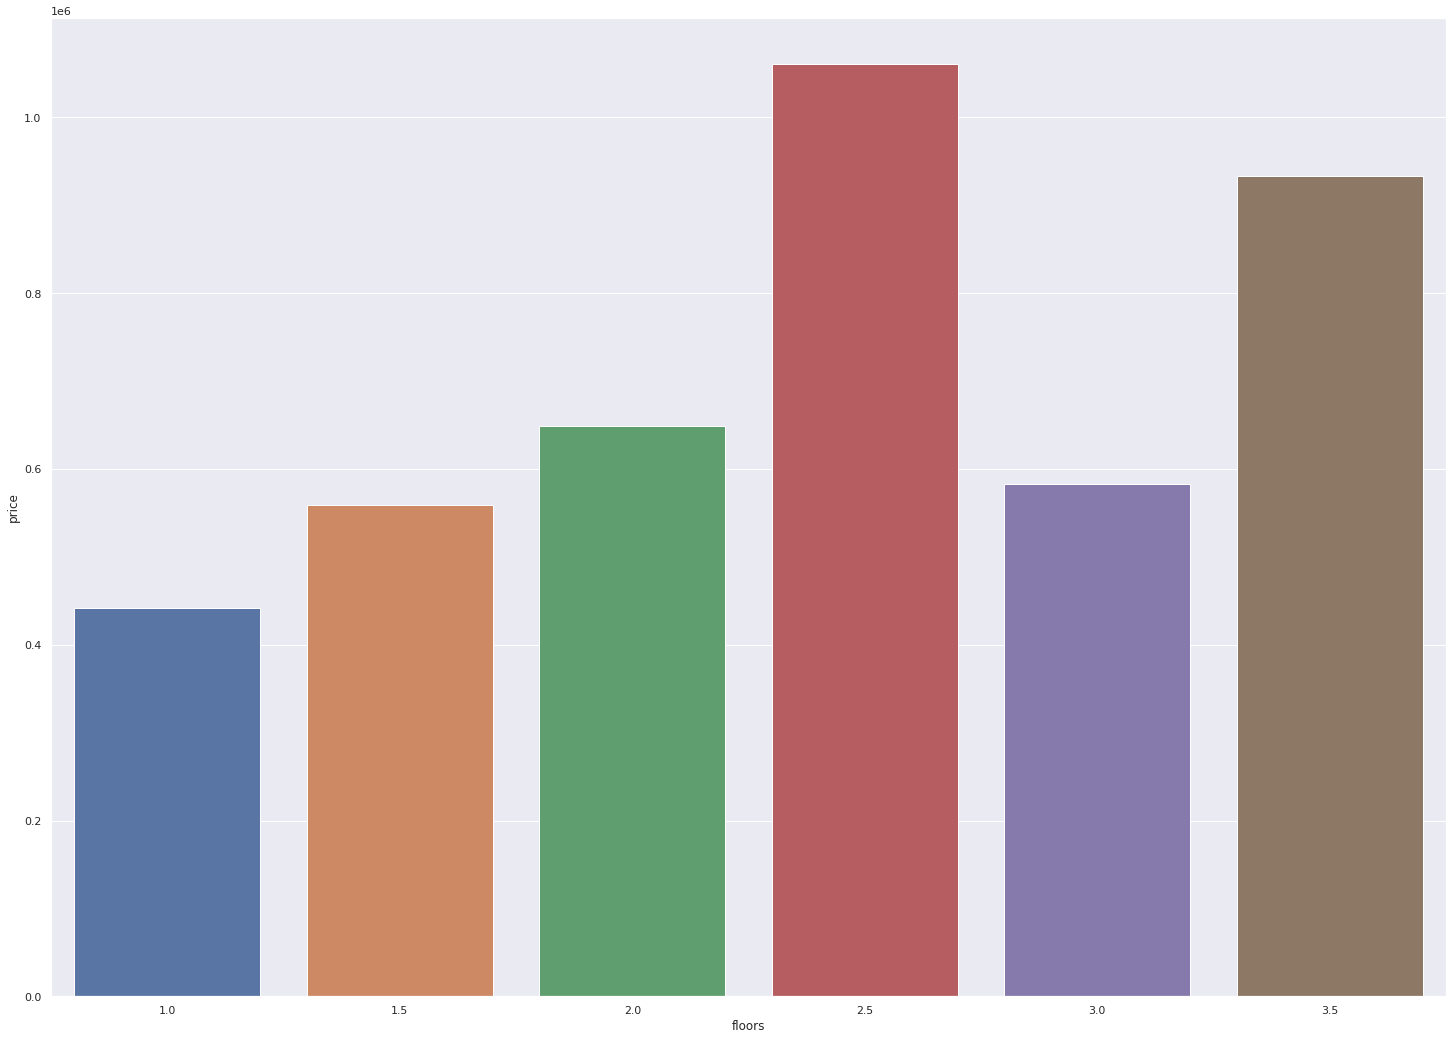

In [104]:

aux = data[['floors', 'price']].groupby('floors').mean().reset_index()

sns.barplot(x='floors',y='price',data=aux
In [101]:
)

#### H9. Os imóveis com melhores condições são pelo menos 50% mais caros que os imóveis com piores condições, em média

Verdade: Os imóveis com melhores condições são 83% mais caros que com piores condições

In [105]:
aux = data[['condition','price']].groupby('condition').mean().reset_index()
aux

,condition,price
0,1,334431.67
1,2,327287.15
2,3,542012.58
3,4,521200.39
4,5,612418.09


In [107]:
data.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,year_week,week,season,city,state,basement,m2,price_m2,semester
0,0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,2014,10,13,2014-41,42,fall,Seattle,Washington,no,524.90,422.75,2
1,1,6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639,2014,12,9,2014-49,50,winter,Seattle,Washington,yes,672.80,799.64,2
2,2,5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062,2015,2,25,2015-08,9,winter,NaN,Washington,no,929.03,193.75,1
3,3,2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000,2014,12,9,2014-49,50,winter,Seattle,Washington,yes,464.52,1300.28,2
4,4,1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503,2015,2,18,2015-07,8,winter,NaN,Washington,no,750.66,679.41,1
